# Neural Machine Translation

Implementation of a neural machine translation system using an **encoder-decoder architecture** with an **attention mechanism** for sequence-to-sequence modeling. The model achieves a **BLEU score of 36** on a German-to-English task, using **beam search**.

## Setup

We will use `pytorch` for modeling and training and `torchtext` for data collection.

Furthermore, we use the BLEU score (see [Papineni et al., "Bleu: a Method for Automatic Evaluation of Machine Translation", 2002](aclweb.org/anthology/P02-1040.pdf)) to evaluate or translation system, with the `sacrebleu` library (see [Post, "A Call for Clarity in Reporting BLEU Scores", 2018](https://www.aclweb.org/anthology/W18-6319.pdf) and [GitHub page](https://github.com/mjpost/sacreBLEU)). SacreBLEU is meant to provide a standardized BLEU score evaluation.

Finally, we will also use `sentencepiece` (see [Github page](https://github.com/google/sentencepiece)) for subword tokenization.

In [2]:
# Install and import dependencies
# Install sacrebleu and sentencepiece
!pip install --upgrade sacrebleu sentencepiece 

# Standard library imports
import json
import math
import random

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import sacrebleu
import sentencepiece
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import tqdm.notebook

     |████████████████████████████████| 61kB 3.4MB/s 
     |████████████████████████████████| 1.1MB 13.6MB/s 
     |████████████████████████████████| 17.1MB 199kB/s 


Let us verify that we're connected to a GPU runtime and that `torch` can detect the GPU. We define a variable `device` here to use throughout the code so that we can easily change to run on CPU for debugging.

In [3]:
assert torch.cuda.is_available()
device = torch.device("cuda")
print("Using device:", device)

Using device: cuda


We use the [Multi30K dataset](https://arxiv.org/abs/1605.00459) (Elliott et al., 2016), which contains English and German captions for images from Flickr. The Multi30K dataset because is simpler than standard translation benchmark datasets and allows for models to be trained and evaluated in a matter of minutes rather than days.



In [4]:
extensions = [".de", ".en"]
source_field = torchtext.data.Field(tokenize=lambda x: x) 
# this does not apply any tokenization, we will use SentencePiece to tokenize the data
# the default tokenizer of the Field function is str.split
target_field = torchtext.data.Field(tokenize=lambda x: x)
training_data, validation_data, test_data = torchtext.datasets.Multi30k.splits(extensions, [source_field, target_field], root=".")


downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 640kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 174kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 162kB/s]


We can iterate over the datasets `training_data`, `validation_data` and `test_data`. For each example in a dataset, the source and targets are accessible with `example.src` and `example.trg` respectively.
 
Let us create a joint German-English subword vocabulary from the training corpus using `sentencepiece`. Since the number of training examples is small, we can choose a smaller vocabulary size than would be used for large-scale NMT. 

The vocabulary consists of four special tokens (`<pad>` for padding, `<s>` for beginning of sentence (BOS), `</s>` for end of sentence (EOS), `<unk>` for unknown) and a mixture of German and English words and subwords. In order to ensure reversability, word boundaries are encoded with a special unicode character "▁" (U+2581).

In [5]:
args = {
    "pad_id": 0,
    "bos_id": 1,
    "eos_id": 2,
    "unk_id": 3,
    "input": "multi30k/train.de,multi30k/train.en",
    "vocab_size": 8000,
    "model_prefix": "multi30k",
}
combined_args = " ".join("--{}={}".format(key, value) for key, value in args.items())
sentencepiece.SentencePieceTrainer.Train(combined_args) 

# this creates two files: multi30k.model (binary file with relevant data for the vocab) 
# and multi30k.vocab (human readable listing of each subword and its associated emission log probability)

# preview the first few rows from the human-readable file using "!head -n 10 multi30k.vocab"

# load the vocabulary from the binary file produced above
vocab = sentencepiece.SentencePieceProcessor()
vocab.Load("multi30k.model")

True

The vocabulary object includes a number of methods for working with full sequences or individual pieces. 

For instance:
* `vocab.EncodeAsPieces(sentence)` returns a list of subword pieces encoded from a string
* `vocab.EncodeAsIds(sentence)` returns a list of subword vocabulary ids encoded from a string
* `vocab.DecodePieces(pieces)` and `vocab.DecodeIds(ids)` return the original string from a list of subword pieces and ids respectively

The beginning of sentence, end of sentence and padding tokens will get filtered out when decoding.

A complete interface can be found on SentencePiece's [GitHub documentation](https://github.com/google/sentencepiece/tree/master/python#usage).

In [6]:
# define some constants for the first three special tokens

pad_id = vocab.PieceToId("<pad>")
bos_id = vocab.PieceToId("<s>")
eos_id = vocab.PieceToId("</s>")

The `make_batch` function converts a list of sentences (of different legnths) into a batch of subword indices with shape `(maximum sequence length, batch size)`, where `maximum sequence length` is the length of the longest sentence encoded by the subword vocabulary. We first augment the sentence using beginning of sentence and end of sentence tokens and then use `pytorch`'s `pad_sequence` function to pad the variable-length sequences to a fixed length using the padding token.

<img src='Padded Sequence.png' style='height:7rem'/>


In [7]:
def make_batch(sentences):
    """
    Args:
        sentences: A list of sentences, each of which is a string.
    Returns:
        A LongTensor of size (max_sequence_length, batch_size) containing the
        subword indices for the sentences.
    """

    sequences = [torch.tensor([bos_id] + vocab.EncodeAsIds(sentence) + [eos_id]) for sentence in sentences]
    sequences = nn.utils.rnn.pad_sequence(sequences, padding_value = pad_id, batch_first = False).to(device)
    return sequences

def make_batch_iterator(dataset, batch_size, shuffle=False):
    """Make a batch iterator that yields source-target pairs.

    Args:
        dataset: A torchtext dataset object.
        batch_size: An integer batch size.
        shuffle: A boolean indicating whether to shuffle the examples.

    Yields:
        Pairs of tensors constructed by calling the make_batch function on the
        source and target sentences in the current group of examples. The max
        sequence length can differ between the source and target tensor, but the
        batch size will be the same. The final batch may be smaller than the given
        batch size.
    """

    examples = list(dataset)
    if shuffle:
        random.shuffle(examples) # the function shuffles in place

    for start_index in range(0, len(examples), batch_size):
        example_batch = examples[start_index:start_index + batch_size] 
        # it is okay if start_index + batch_size > len(examples), only the minimum of the two will be selected
        source_sentences = [example.src for example in example_batch]
        target_sentences = [example.trg for example in example_batch]
        yield make_batch(source_sentences), make_batch(target_sentences)

# The yield statement suspends a function’s execution 
# and sends a value back to the caller, but retains enough state 
# to enable function to resume where it is left off

## The model: biLSTM encoder & LSTM decoder with attention

The model consists of a **bidirectional LSTM encoder** that encodes the input sentence into a fixed-size representation, and an **LSTM decoder** that uses this representation to produce the output sentence. For background on bilinear RNNs and encoder-decoder architectures, see [Jurafsky & Martin, "Speech and Language Processing" Chapter 9 and 10](https://web.stanford.edu/~jurafsky/slp3/) respectively.

### The bidirectional LSTM encoder

The motivation behind the bidirectional LSTM encoder is to exploit the fact that we have access to the entire input sequence at once during training. Therefore, we use the context to the left of the current input word (forward LSTM) as well as the context to the right of the current input word (backward LSTM):

<img src='bilinear LSTM.png'/>

For a given word, the states (state = hidden state and context vector) of the forward LSTM and backward LSTM are concatenated. We then perform an operation the backward and forward states (e.g. sum, average, linear transformation). The following figure sums up this model architecture:

<img src='LSTM architecture.png'/>

We will also include a dropout of $0.5$ between LSTM layers.

### How is the network trained?

To compute the loss, we pass the source sentence (in German) through the encoder to get the hidden state and context vector of the last word in the sentence (i.e. the state of the entire encoded sentence). We then pass the words $1$ to $n-1$ of the target sentence (in English) as input to the decoder to predict the words $2$ to $n$. 

Each input word at position $k$ is responsible for predicting a probability distribution over the vocabulary which should assign a probability of $1$ to the word in position $k+1$ and $0$ everywhere else. We compare the predicted and target distribution using the cross entropy loss, which is then averaged over the whole batch.

In the following example, the decoder input `<bos>` is responsible for predicting `A`, `A` is responsible for predicting `little`, and so on (the last target is the `<eos>` token). Each step uses the previous step's hidden state (which encompasses the hidden state of the whole sentence up to this last word) to predict the current vocabulary distribution.

<img src='loss computation.png' style='height:50rem'/>

### Including attention

Next, we extend the baseline model to include an **attention mechanism** in the decoder. This circumvents the need to store all information about the source sentence in a fixed-size representation (e.g. the final hidden state, which inevitably is more focused on the latter parts of the input sequence).

We will implement **bilinear attention**, where the attention distribution over the encoder outputs $e_1, \dots, e_n$ given a decoder LSTM output $d$ is obtained via a softmax of the dot products after a suitable projection: $\alpha_i \propto \exp ( e_i^\top W d )$. The unnormalized attention logits for encoder outputs corresponding to padding tokens should be offset with a large negative value to ensure that the corresponding attention weights are $0$.

<img src='attention1.png'/>

After computing the attention distribution, we take a weighted sum of the encoder outputs to obtain the attention context $c = \sum_i \alpha_i e_i$, and add this to the decoder output $d$ to obtain the final representation to be passed to the vocabulary projection layer (we may need another linear layer to make the sizes match before adding $c$ and $d$).

<img src='attention2.png'/>

In [8]:
class Seq2seqAttention(nn.Module):
  def __init__(self):
    super().__init__()

    vocab_size = vocab.GetPieceSize()
    self.embedding = nn.Embedding(vocab_size, 256)
    self.lstm_encoder = nn.LSTM(256, 256, 2, dropout = 0.5, bidirectional = True)
    self.lstm_decoder = nn.LSTM(256, 256, 2, dropout = 0.5)
    self.linear = nn.Linear(256,vocab_size)
    self.W = nn.Linear(2*256, 256, bias=False)
    self.proj = nn.Linear(512,256, bias=False)

  def encode(self, source):
    """
    Args:
      source: An integer tensor with shape (max_source_sequence_length,
        batch_size) containing subword indices for the source sentences.

    Returns:
      A tuple with three elements:
        encoder_output: The output (states of each word in the sequences) of the bidirectional LSTM with shape
          (max_source_sequence_length, batch_size, 2 * hidden_size)
          2 * hidden_size comes from the concatenated hidden states of the bidirectional LSTM

        encoder_mask: A boolean tensor with shape (max_source_sequence_length,
          batch_size) indicating which encoder outputs correspond to padding
          tokens.

        encoder_hidden: The final hidden states of the bidirectional LSTM (after
          a suitable projection) that will be used to initialize the decoder.
          This should be a pair of tensors (h_n, c_n), each with shape
          (num_layers, batch_size, hidden_size). Note that the hidden state
          returned by the LSTM cannot be used directly. Its initial dimension is
          twice the required size because it contains state from two directions.
    """
    batch_size = source.shape[1]
    x = self.embedding(source).view(-1, batch_size, 256)

    # initialize the hidden state and context vector to zero
    # define it on the cuda device or colab will crash
    h_0 = torch.zeros(4, batch_size, 256, device=device)
    c_0 = torch.zeros(4, batch_size, 256, device=device)

    output, hidden = self.lstm_encoder(x, (h_0, c_0))
    h_n, c_n = hidden

    # take the sum of the hidden states and context vectors from both directions
    h_n = h_n[:2,:,:] + h_n[2:,:,:]
    c_n = c_n[:2,:,:] + c_n[2:,:,:]

    # use a large negative number like -1e9 instead of float("-inf") when
    # masking padding tokens to avoid numerical issues.
    mask = torch.zeros_like(source).masked_fill_(source == pad_id, -1e9)

    return output, mask, (h_n, c_n)

  def decode(self, decoder_input, initial_hidden, encoder_output, encoder_mask):
    """
    Run the LSTM decoder starting from an initial hidden state.

    Args:
      decoder_input: An integer tensor with shape (max_decoder_sequence_length,
        batch_size) containing the subword indices for the decoder input. During
        evaluation, where decoding proceeds one step at a time, the initial
        dimension should be 1.

      initial_hidden: A pair of tensors (h_0, c_0) representing the initial
        state of the decoder, each with shape (num_layers, batch_size,
        hidden_size), this corresponds to the output "encoder_hidden" in the 
        above function.

      encoder_output: The output of the encoder with shape
        (max_source_sequence_length, batch_size, 2 * hidden_size).

      encoder_mask: The output mask from the encoder with shape
        (max_source_sequence_length, batch_size). Encoder outputs at positions 
        that correspond to padding tokens and should be ignored.

    Returns:
      A tuple with three elements:
        logits: A tensor with shape (max_decoder_sequence_length, batch_size,
          vocab_size) containing unnormalized scores for the next-word
          predictions at each position.

        decoder_hidden: A pair of tensors (h_n, c_n) with the same shape as
          initial_hidden representing the updated decoder state after processing
          the decoder input.

        attention_weights: A tensor with shape (max_decoder_sequence_length,
          batch_size, max_source_sequence_length) representing the normalized
          attention weights. This should sum to 1 along the last dimension.
    """
    # define some useful constants
    max_source_len = encoder_output.shape[0]
    max_decoder_len = decoder_input.shape[0]
    batch_size = decoder_input.shape[1]

    x = self.embedding(decoder_input).view(-1, batch_size, 256)
    decoder_output, decoder_hidden = self.lstm_decoder(x, initial_hidden) # decoder_output has shape (max_decoder_len, batch_size, 256)

    alpha = self.W(encoder_output) # (max_source_len, batch_size, 512 -> 256)
    alpha = torch.einsum('lik,mik->lim', [alpha, decoder_output]) # (max_source_len, batch_size, max_decoder_len)
    # See https://rockt.github.io/2018/04/30/einsum for a tutorial on the function `einsum`.

    # mask padding tokens
    alpha = F.softmax(alpha + encoder_mask.unsqueeze(2).repeat(1,1,max_decoder_len), dim = 0) # (max_source_len, batch_size, max_decoder_len)

    c = torch.einsum('nil,nih->lih', [alpha, encoder_output])
    logits = self.proj(c) + decoder_output
    logits = self.linear(logits)
    return logits, decoder_hidden, alpha

  def compute_loss(self, source, target):
    """
    Run the model on the source and compute the loss on the target.

    Args:
      source: An integer tensor with shape (max_source_sequence_length,
        batch_size) containing subword indices for the source sentences.
      target: An integer tensor with shape (max_target_sequence_length,
        batch_size) containing subword indices for the target sentences.

    Returns:
      A scalar float tensor representing cross-entropy loss on the current batch.
    """
    vocab_size = vocab.GetPieceSize()
    batch_size = source.shape[1]
    encoder_output, encoder_mask, hidden = self.encode(source)
    decoder_input = target[:-1]
    logits, _, _ = self.decode(decoder_input, hidden, encoder_output, encoder_mask)
    loss = F.cross_entropy(logits.permute(1, 2, 0), target[1:].permute(1,0)) 
    # put the batch dimension first and vocab dimension second
    return loss.mean()

We define the following functions for training. We use `pytorch`'s implementation of Adam optimizer ([Adam: A Method for Stochastic Optimization by Diederik et al. (2017)](https://arxiv.org/abs/1412.6980)) with default parameters (we could also include learning rate decay).


In [9]:
def train(model, num_epochs, batch_size, model_file):
  """Train the model and save its best checkpoint.
  
  Model performance across epochs is evaluated using token-level accuracy on the
  validation set. The best checkpoint obtained during training will be stored on
  disk and loaded back into the model at the end of training.
  """
  optimizer = torch.optim.Adam(model.parameters())
  best_accuracy = 0.0
  for epoch in tqdm.notebook.trange(num_epochs, desc="training", unit="epoch"):
    with tqdm.notebook.tqdm(
        make_batch_iterator(training_data, batch_size, shuffle=True),
        desc="epoch {}".format(epoch + 1),
        unit="batch",
        total=math.ceil(len(training_data) / batch_size)) as batch_iterator: # define tqdm progress bar
      model.train() # put model in train mode
      total_loss = 0.0
      for i, (source, target) in enumerate(batch_iterator, start=1):
        optimizer.zero_grad()
        loss = model.compute_loss(source, target)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        batch_iterator.set_postfix(mean_loss=total_loss / i) # Specify additional stats to display at the end of the tqdm progress bar
      validation_perplexity, validation_accuracy = evaluate_next_token(
          model, validation_data)
      batch_iterator.set_postfix(
          mean_loss=total_loss / i,
          validation_perplexity=validation_perplexity,
          validation_token_accuracy=validation_accuracy)
      if validation_accuracy > best_accuracy: # only save checkpoint of the model if validation accuracy improved (prevents overfitting)
        print(
            "Obtained a new best validation accuracy of {:.2f}, saving model "
            "checkpoint to {}...".format(validation_accuracy, model_file))
        torch.save(model.state_dict(), model_file)
        best_accuracy = validation_accuracy
  print("Reloading best model checkpoint from {}...".format(model_file)) # load the best model after training
  model.load_state_dict(torch.load(model_file))

def evaluate_next_token(model, dataset, batch_size=64):
  """Compute token-level perplexity and accuracy metrics.

  Note that the perplexity here is over subwords, not words.
  
  This function is used for validation set evaluation at the end of each epoch
  """
  model.eval()
  total_cross_entropy = 0.0
  total_predictions = 0
  correct_predictions = 0
  with torch.no_grad():
    for source, target in make_batch_iterator(dataset, batch_size):
      encoder_output, encoder_mask, encoder_hidden = model.encode(source)
      decoder_input, decoder_target = target[:-1], target[1:]
      logits, decoder_hidden, attention_weights = model.decode(
          decoder_input, encoder_hidden, encoder_output, encoder_mask)
      total_cross_entropy += F.cross_entropy(
          logits.permute(1, 2, 0), decoder_target.permute(1, 0),
          ignore_index=pad_id, reduction="sum").item() 
          # specify ignore_index = pad_id to not take the padding tokens into account in the loss
      total_predictions += (decoder_target != pad_id).sum().item()
      correct_predictions += (
          (decoder_target != pad_id) &
          (decoder_target == logits.argmax(2))).sum().item()
  perplexity = math.exp(total_cross_entropy / total_predictions)
  accuracy = 100 * correct_predictions / total_predictions
  return perplexity, accuracy

Since we haven't yet defined a decoding method to output an entire string, we will measure performance for now by computing perplexity and the accuracy of predicting the next token given a gold prefix of the output.

In [10]:
# Run this code to load a pre-trained model

attention_model = Seq2seqAttention().to(device)
model_file = 'attention_model.pt'
attention_model.load_state_dict(torch.load(model_file))

p, a = evaluate_next_token(attention_model, validation_data)
print('\nPerplexity: {}\nAccuracy: {}\n'.format(p,a))


Perplexity: 6.391459564401712
Accuracy: 65.22867737948084



In [ ]:
# Run this code to train the model from scratch
 
num_epochs = 10
batch_size = 16

attention_model = Seq2seqAttention().to(device)
train(attention_model, num_epochs, batch_size, "attention_model.pt")

### Generate Predictions

For evaluation, we also need to be able to generate entire strings from the model. We will first define a greedy inference procedure here. Later on, we will implement beam search.

#### Greedy Search

At each step we select the word with the highest logit score to be added to the prediction string. 

<img src='Greedy_Decoding.png'/>

The implementation is batched, meaning we make only one call to `model.encode()` at the start of the function, and make only one call to `model.decode()` at each inference step.

Once an EOS token has been been generated, we force the output for that prediction to be padding tokens in all subsequent time steps by adding a large positive number (1e9 e.g.) to the appropriate logits.


In [11]:
def predict_greedy(model, sentences, max_length=20):
    """Make predictions for the given inputs using greedy inference.
    
    Args:
        model: A sequence-to-sequence model.
        sentences: A list of input sentences, represented as strings.
        max_length: The maximum length at which to truncate outputs in order to
        avoid non-terminating inference.
    
    Returns:
        A list of predicted translations, represented as strings.
    """
    vocab_size = vocab.GetPieceSize()
    source = make_batch(sentences)
    encoder_output, encoder_mask, decoder_hidden = model.encode(source)
    batch_size = len(sentences)
    target = np.array([bos_id for _ in range(batch_size)]).reshape(1,batch_size)
    counter_eos = np.zeros(batch_size)
    cpt = 1
    scores = np.zeros((1,batch_size)) #enlever
    #print(decoder_hidden[0])
    while counter_eos.sum() < batch_size and cpt<max_length:
        cpt+=1
        decoder_input = torch.tensor(target[-1, :], device = device).unsqueeze(0)
        logits, decoder_hidden, _ = model.decode(decoder_input, decoder_hidden, encoder_output, encoder_mask)
        logits  = F.log_softmax(logits, dim = -1) #ENLEVER
        logits = logits.detach().cpu().numpy().reshape(batch_size, vocab_size)
        pred = np.argmax(logits, axis = 1).reshape(1, batch_size)
        new_scores = np.max(logits, axis = 1).reshape(1, batch_size) #enlever
        #print('score', scores)
        scores = scores + new_scores #enlever
        #print('new', new_scores)
        pred = np.where(counter_eos == 1, pad_id, pred)
        counter_eos = np.where(pred == eos_id, 1, counter_eos)
        target = np.concatenate((target, pred), axis = 0)
    target = target.T.tolist()
    target = [vocab.DecodeIds(row) for row in target]
    return target
        
def evaluate(model, dataset, batch_size=64, method="greedy"):
  assert method in {"greedy", "beam"}
  source_sentences = [example.src for example in dataset]
  target_sentences = [example.trg for example in dataset]
  model.eval()
  predictions = []
  with torch.no_grad():
    for start_index in range(0, len(source_sentences), batch_size):
      if method == "greedy":
        prediction_batch = predict_greedy(
            model, source_sentences[start_index:start_index + batch_size])
      else:
        prediction_batch = predict_beam(
            model, source_sentences[start_index:start_index + batch_size])
        prediction_batch = [candidates[0] for candidates in prediction_batch]
      predictions.extend(prediction_batch)
  return sacrebleu.corpus_bleu(predictions, [target_sentences]).score

In [12]:
print("Attention model validation BLEU using greedy search:",
      evaluate(attention_model, validation_data))

Attention model validation BLEU using greedy search: 35.29444453352635


## Beam Search

the order of the reshaoe and view function is very important

Greedy search leads to suboptimal results. By keeping only the single best hypothesis at each time step, we do not explore other candidates which could lead to greater scores on subsequent steps. In order to explore the search space a little more, we implement beam search.

As in greedy search, beam search generates one token at a time. However, rather than keeping only the single best hypothesis, we instead keep the top $k$ candidates at each time step. This is accomplished by computing the set of next-token extensions for each item on the beam and finding the top $k$ across all candidates according to total log-probability.

Candidates that are finished should stay on the beam through the end of inference. The search process concludes once all $k$ items on the beam are complete.

As in greedy search, the implementation is batched and once an EOS token has been generated, we force the output for that candidate to be padding tokens in all subsequent time steps by adding a large positive number like 1e9 to the appropriate logits. This will ensure that the candidate stays on the beam, as its probability will be very close to 1 and its score will effectively remain the same as when it was first completed.  All other (invalid) token continuations will have extremely low log probability and will not make it onto the beam.

<img src='beam_search.png' style='height:30rem'/>

<center>Figure taken from <span style='font-style:italic'>Jurafsky & Martin</span>.</center>

Moreover, some special care will need to be taken on the first iteration to ensure that the beam doesn't fill up with k identical copies of the same candidate.

Note: for $k = 1$, we should observe the same predictions as in greedy search.

In [43]:
def predict_beam(model, sentences, k=5, max_length=20):
    """Make predictions for the given inputs using beam search.
    
    Args:
        model: A sequence-to-sequence model.
        sentences: A list of input sentences, represented as strings.
        k: The size of the beam.
        max_length: The maximum length at which to truncate outputs in order to
        avoid non-terminating inference.
  
    Returns:
        A list of beam predictions. Each element in the list should be a list of k
        strings corresponding to the top k predictions for the corresponding input,
        sorted in descending order by score.
    """
    vocab_size = vocab.GetPieceSize()
    batch_size = len(sentences)

    source = make_batch(sentences)
    source = source.repeat(1,k) # (max_source_length, k*batch_size)
    encoder_output, encoder_mask, decoder_hidden = model.encode(source)

    targets = bos_id*torch.ones(1, k, batch_size, device = device, dtype = torch.long)
    # shape: (number of words in target sequence, k candidates, batch_size)

    counter = 0
    with torch.no_grad():

        while counter < max_length:
            counter += 1
            
            logits, decoder_hidden, _ = model.decode(targets[-1,:,:].view(1, k*batch_size), decoder_hidden, encoder_output, encoder_mask)

            # logits has shape (current length, k*batch_size, vocab_size)
            logits = logits.view(-1, k, batch_size, vocab_size)
            logits = logits[-1, :, :, :] # we only keep the prediction of the target sequence's last word
            logits = logits.permute(1,0,2) # (batch_size, k, vocab_size)
            # the order of the shapes are very important

            if counter == 1: 
                logits = logits[:, 0, :] # shape (batch_size, vocab_size)
                # special case for the first iteration:
                # we only keep the first candidate's top k predictions otherwise the beam is going to fill up with the k same first words
                scores, indices = F.log_softmax(logits, dim = -1).topk(k, dim = -1) # scores and indices have shape (batch_size, k)
                targets = torch.cat([targets, indices.permute(1,0).unsqueeze(0)], dim = 0)
                # targets now has shape (2, k, batch_size)
                eos_mask = [np.where(targets[:,:,i].cpu().numpy() == eos_id)[1] for i in range(batch_size)]

            else:
                logits = F.log_softmax(logits, dim = -1)

                targets_list = []
                h,c = decoder_hidden

                for i in range(batch_size):
                    batch_logits = torch.clone(logits[i, :, :])
                    batch_logits[eos_mask[i], pad_id] = 0.
                    # Once an EOS token has been generated, force the output for that candidate to be padding tokens: log(1) = 0
                    # It will be selected since its probability is not decreasing: log(proba) <= 0
                    batch_logits = batch_logits + scores[i, :][:, None]
                    batch_logits = batch_logits.flatten()
                    batch_scores, indices = batch_logits.topk(k, dim = -1, sorted = True)
                    indices = indices.cpu().numpy()
                    indices = np.unravel_index(indices, shape=(k,vocab_size))
                    keep_targets = targets[:, indices[0], i]
                    new_words = torch.tensor(indices[1]).view(1, k)
                    new_targets = torch.cat([keep_targets, new_words.to(device)], dim = 0) # (current length + 1, k)
                    scores[i, :] = batch_scores

                    eos_mask[i] = np.where(new_targets.cpu().numpy() == eos_id)[1]
                    # We discard the information about the placement of the eos_id token (dimension 0) and only keep information about the candidate

                    # We need to adapt the indices to the placement of each candidate in the hidden vector
                    # i.e. c_00, c_10, c01, c11, ... if we denote c_00 the candidate 0 of batch 0
                    h[:, batch_size*np.arange(k) + i, :] = h[:, batch_size*indices[0] + i, :]
                    c[:, batch_size*np.arange(k) + i, :] = c[:, batch_size*indices[0] + i, :]
                    # We need to change every tensor to select the candidates we chose to keep
                    targets_list.append(new_targets.unsqueeze(2))

                targets = torch.cat(targets_list, dim = -1)
                decoder_hidden = (h,c)
       
    output = [[vocab.DecodeIds(col) for col in row] for row in targets.T.tolist()]
    # output the top k prediction sorted by score in descending order for each input in the batch
    # candidates were already sorted after the topk

    return output


In [14]:
print("Attention model validation BLEU using beam search:",
      evaluate(attention_model, validation_data, method="beam"))

Attention model validation BLEU using beam search: 36.09787302225476


That is, an improvement of almost one point compared to greedy inference. Let's look at some of the predictions:

In [15]:
for example in validation_data[:2]:
    print("Input:\n", example.src)
    print("\nTarget:\n", example.trg)
    print("\nGreedy prediction:\n", predict_greedy(attention_model, [example.src])[0])
    print("\nBeam predictions:")
    for candidate in predict_beam(attention_model, [example.src])[0]:
        print("", candidate)
    print('\n')

Input:
 Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen

Target:
 A group of men are loading cotton onto a truck

Greedy prediction:
 A group of men loading trees on a truck

Beam predictions:
 A group of men unloading tree
 A group of men loading trees on a truck
 A group of men loading homes on a truck
 A group of men are loading trees on a truck
 A group of men loading trees on a truck.


Input:
 Ein Mann schläft in einem grünen Raum auf einem Sofa.

Target:
 A man sleeping in a green room on a couch.

Greedy prediction:
 A man sleeping in a green room on a couch.

Beam predictions:
 A man sleeping in a green room on a couch.
 A man sleeping on a couch in a green room.
 A man sleeping on a couch inside a green room.
 A man sleeping in a green room.
 A man is sleeping in a green room on a couch.




## Attention visualization

Once you have everything working in the sections above, add some code here to visualize the decoder attention learned by the attention model using `matplotlib`. Your notebook should include some images of attention distributions for examples from the validation set and a few sentences analyzing the results. You will also be asked to include a representative attention visualization plot as part of your submission.

You may visualize decoder attention on gold source-target pairs from the validation data. You do not need to run any inference in this section.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


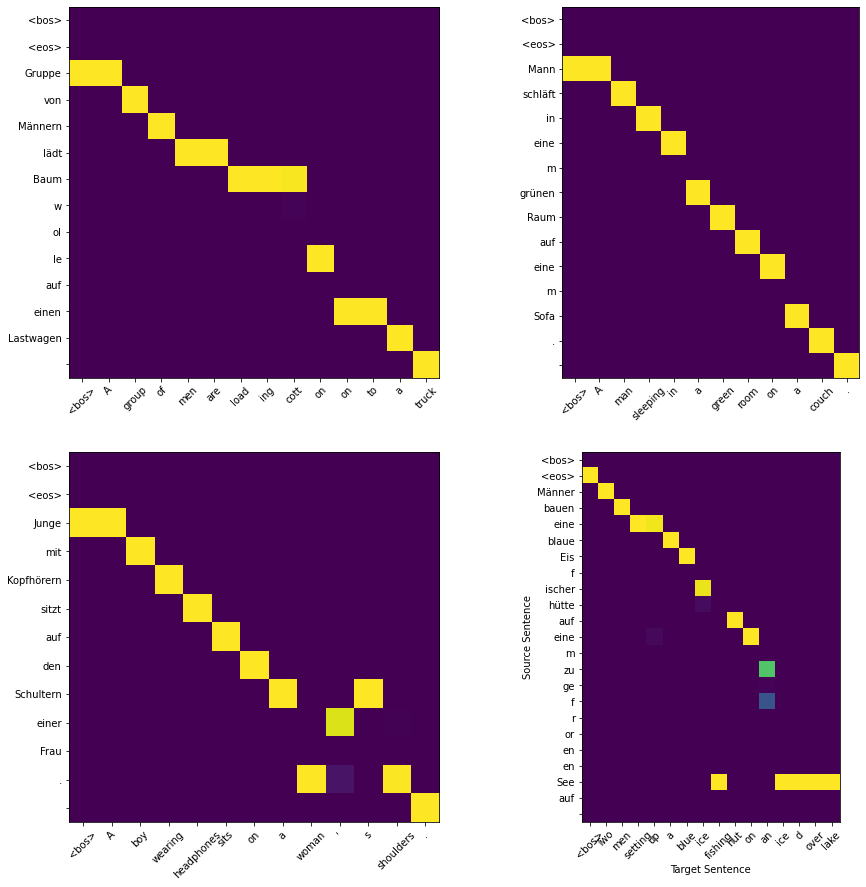

In [16]:
import seaborn as sns
fig, ax = plt.subplots(2, 2, figsize=(15,15))

for i in range(4):
    source = make_batch([validation_data[i].src])
    target = make_batch([validation_data[i].trg])

    encoder_output, encoder_mask, encoder_hidden = attention_model.encode(source)
    decoder_input, decoder_target = target[:-1], target[1:]
    _, _, attention_weights = attention_model.decode(decoder_input, encoder_hidden, encoder_output, encoder_mask)
    attention_weights = attention_weights.detach().cpu().numpy().squeeze()
    
    idx = np.unravel_index(i, shape = (2,2))
    im = ax[idx].imshow(attention_weights)

    ax[idx].set_yticks(np.arange(len(source)))
    ax[idx].set_xticks(np.arange(len(target[:-1])))

    ylabels = [vocab.DecodeIds([word]) for word in source.flatten().cpu().numpy().tolist()]
    ylabels[0], ylabels[1] = '<bos>', '<eos>' # DecodeIds returns empty string for bos and eos tags
    xlabels = [vocab.DecodeIds([word]) for word in target[:-1].flatten().cpu().numpy().tolist()]
    xlabels[0] = '<bos>'
    ax[idx].set_yticklabels(ylabels)
    ax[idx].set_xticklabels(xlabels)

    plt.setp(ax[idx].get_xticklabels(), rotation=45)
    plt.xlabel('Target Sentence')
    plt.ylabel('Source Sentence')

Generally, it seems that the attention gives all of the weight to encoder and decoder hidden states that have approximately the same place in the sentence.This results in an almost identity-like attention matrix. 
<br><br>In some cases however, we can see the weight beginning to spread further from the diagonal, implying that certain dependencies between words arise in different orders. 
<br><br>
For example, the end of the second source sentence is: "den Schultern einer Frau" which correspond to the target "a woman's shoulders". As the genitive takes a different form in english and in german, we can see the attention mechanism is attributing weights to words in a different order to adapt to this syntax.
<br><br>
Additionally, some words and adjectives can be combined into one in german (*Eisfischerhütte* becomes *ice fishing hut*), which results in zero entries in the attention weights. There is also syntactic dependencies at the end of the sentence that require looking at the words in a different order.
<br><br>
Mostly, the observed differences come from syntactic differences between both languages.